In [8]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [17]:
def encode_words(model_name_or_path, tuples):
    """
    Given a list of sentences and a model, get the embeddings of each word in the sentences.
    """
    sentences = [x[0] for x in tuples]
    
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir ='../_cache') # Will output all hidden_states.

    print("   Tokenizing sentences...")
    marked_text = ["[CLS] " + sent + " [SEP]" for sent in sentences]
    tokenized_text = [tokenizer.tokenize(sent) for sent in marked_text]
    indexed_tokens = [tokenizer.convert_tokens_to_ids(sent) for sent in tokenized_text]
    #indexed_tokens = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in indexed_tokens]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(indexed_tokens, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # Concatenate the tensors for all layers. We use `stack` here to create a new dimension in the tensor.
    hidden_states = torch.stack(output[2], dim=0)

    # Switch around the “layers” and “tokens” dimensions with permute.
    hidden_states = hidden_states.permute(1,2,0,3)
    
    # For each sentence, sum the last four layers of each token as their embbeding.
    sentence_vecs = []
    for sent in hidden_states:
        token_vecs = []
        for token in sent:
            sum_vec = torch.sum(token[-4:], dim=0)
            token_vecs.append(np.array(sum_vec))
        sentence_vecs.append(token_vecs)
    sentence_vecs = np.array(sentence_vecs)
        
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(sentence_vecs.shape[2])]
    df = pd.DataFrame(columns=cols)
    df['Token'] = None
    df['Sentence'] = None
    
    for i, sent in enumerate(sentences):
        tmp_df = pd.DataFrame(data=sentence_vecs[i,:,:], columns=cols)
        tmp_df['Token'] = list(np.append(tokenized_text[i], ['[PAD]']*(max_len-len(tokenized_text[i]))))
        tmp_df['Sentence'] = [sent]*max_len
        df = pd.concat([df, tmp_df], axis=0)
    
    df = df.loc[~df['Token'].isin(['[CLS]', '[SEP]', '[PAD]'])]
    df.reset_index(drop=True, inplace=True)
    return df



def get_embeddings(df, tuples, model_name_or_path):
    """
    Given the dataframe, get the embeddings of each word.
    """
    sentences = [x[0] for x in tuples]
    words_of_interest = [x[1] for x in tuples]
    classes = [x[2] for x in tuples]
    
    embeddings = []
    for i, sent in enumerate(sentences):
        
        # If word_i is entirely present (not segmented), take its embedding.
        if words_of_interest[i] in df.loc[df["Sentence"]==sent, "Token"].values.tolist():
            word_embedding = df.loc[(df['Sentence']==sent) & (df['Token']==words_of_interest[i]), ~df.columns.isin(['Token','Sentence'])].values[0]
            embeddings.append(word_embedding)

        # If word is segmented, find the n-grams and average their embeddings.
        else:
            tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
            grams = tokenizer.tokenize(words_of_interest[i])
            avg_df = df.loc[(df['Sentence']==sent) & (df['Token'].isin(grams)), ~df.columns.isin(['Token','Sentence'])]
            avg = avg_df.mean(axis=0).values
            embeddings.append(avg)
    
    # Create pandas dataframe.
    cols = ['feat'+str(i) for i in range(len(embeddings[0]))]
    df = pd.DataFrame(data=np.array(embeddings), columns=cols)
    df['Word'] = words_of_interest
    df['Class'] = classes
    return df, np.array(embeddings)


def perform_tsne(df_embeddings):
    """
    """
    df = df_embeddings.copy(deep=True)
    
    ## Use PCA to reduce dimensions to a number that's manageable for t-SNE
    data = df.loc[:, ~df.columns.isin(['Word','Class'])].values
    pca_50 = PCA(n_components=50, random_state=42)
    pca_result_50 = pca_50.fit_transform(data)
    print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

    # Reduce dimensionality to 3 with t-SNE.
    #for i in range(5, 55, 5):
    tsne = TSNE(n_components=3, 
                perplexity=10, # usually in the range [5, 50] -> perplexity is related to the number of nearest neighbors (larger datasets usually require a larger perplexity).
                n_iter=2000, 
                learning_rate=400, # usually in the range [10, 1000] -> If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours.
                random_state=42, 
                verbose=0)
    tsne_pca_results = tsne.fit_transform(pca_result_50)

    # Add results to dataframe
    df['tsne-1'] = tsne_pca_results[:,0]
    df['tsne-2'] = tsne_pca_results[:,1]
    df['tsne-3'] = tsne_pca_results[:,2]

    # Plot 2D.
    fig = plt.figure(figsize=(22,7))
    ax1 = fig.add_subplot(1, 2, 1)
    sns.scatterplot(x = df['tsne-1'], 
                    y = df['tsne-2'],
                    hue = df['Class'],
                    alpha=1.0,
                    linewidth=0)
    ax1.set_xlabel('tsne-1', fontsize=18, labelpad=10)
    ax1.set_ylabel('tsne-2', fontsize=18, labelpad=10)

    # Plot 3D.
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.scatter(xs=df["tsne-1"], 
                ys=df["tsne-2"], 
                zs=df["tsne-3"], 
                cmap='tab10')
    ax2.set_xlabel('tsne-1', labelpad=10, fontsize=18)
    ax2.set_ylabel('tsne-2', labelpad=10, fontsize=18)
    ax2.set_zlabel('tsne-3', labelpad=10, fontsize=18)

    # Annotate points with labels.
    for line in df.index:
        ax1.text(df.loc[line,"tsne-1"]+0.1, 
                 df.loc[line,"tsne-2"], 
                 df.loc[line,"Word"], 
                 horizontalalignment='left', 
                 size=1, 
                 color='gray', 
                 weight='semibold')
        ax2.text(df.loc[line,"tsne-1"]+0.1, 
                 df.loc[line,"tsne-2"], 
                 df.loc[line,"tsne-3"], 
                 df.loc[line,"Word"], 
                 horizontalalignment='left', 
                 size=1, 
                 color='gray', 
                 weight='semibold')
    fig.show()
    return


def perform_kmeans(embeddings, nb_clusters=4):
    """
    """
    km = KMeans(n_clusters=nb_clusters, 
                    init='k-means++',
                    n_init=10, 
                    max_iter=300, 
                    tol=1e-04, 
                    random_state=42)
    kmeans = km.fit(embeddings)
    
    return kmeans.labels_, kmeans.cluster_centers_


def run_all(tuples):
    """
    """
    print("BERT-base")
    bert_df = encode_words('bert-base-cased', tuples)
    bert_df_embeddings, bert_embeddings = get_embeddings(bert_df, tuples, 'bert-base-cased')
    perform_tsne(bert_df_embeddings)
    bert_km_labels, bert_km_centers = perform_kmeans(bert_embeddings)
    print(bert_km_labels)
    
    print("NetBERT")
    netbert_df = encode_words('../_models/netbert-final/', tuples)
    netbert_df_embeddings, netbert_embeddings = get_embeddings(netbert_df, tuples, '../_models/netbert-final/')
    perform_tsne(netbert_df_embeddings)
    netbert_km_labels, netbert_km_centers = perform_kmeans(netbert_embeddings)
    print(netbert_km_labels)

    return


BERT-base
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 12 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
Cumulative explained variation for 50 principal components: 0.9762795567512512
[0 0 2 1 1 0 0 3 0 0 2 2 2 0 0 2 2 0 0 1 1 0 1 2 3 2 3 0 0 2 2 2 3 0 3 0 3
 2 3 2 0 0 2 1 1 1 0 0 0 0 1 0 0 3 0 0 0 3 3 0 0 3 2 0 0 3 3]
NetBERT
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 12 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...
Cumulative explained variation for 50 principal components: 0.9632098078727722
[0 2 0 2 2 2 2 0 1 1 0 1 0 2 0 0 0 2 0 0 0 2 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0
 0 0 0 1 1 0 3 3 3 2 3 0 2 3 0 2 0 2 0 2 1 0 1 1 0 0 1 2 1 1]


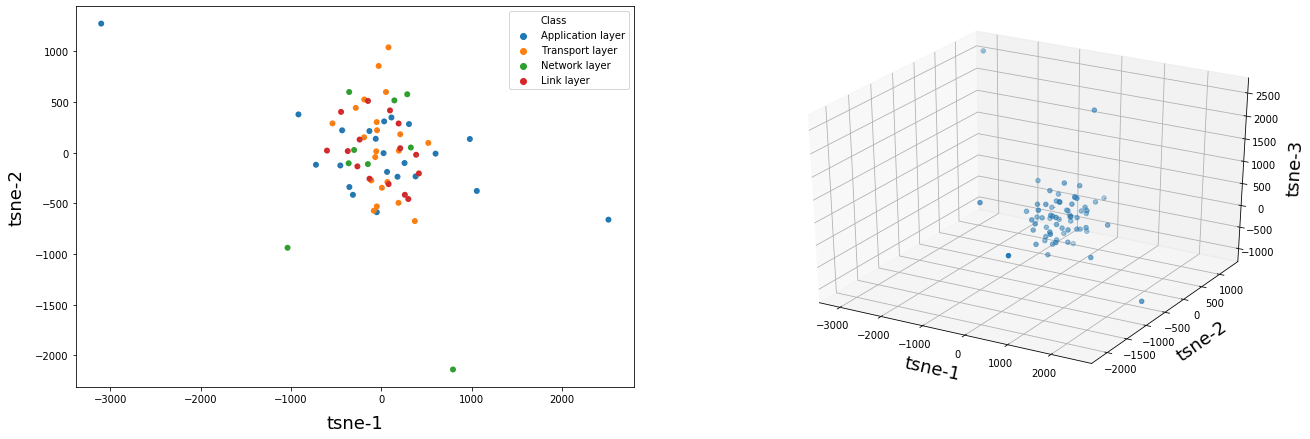

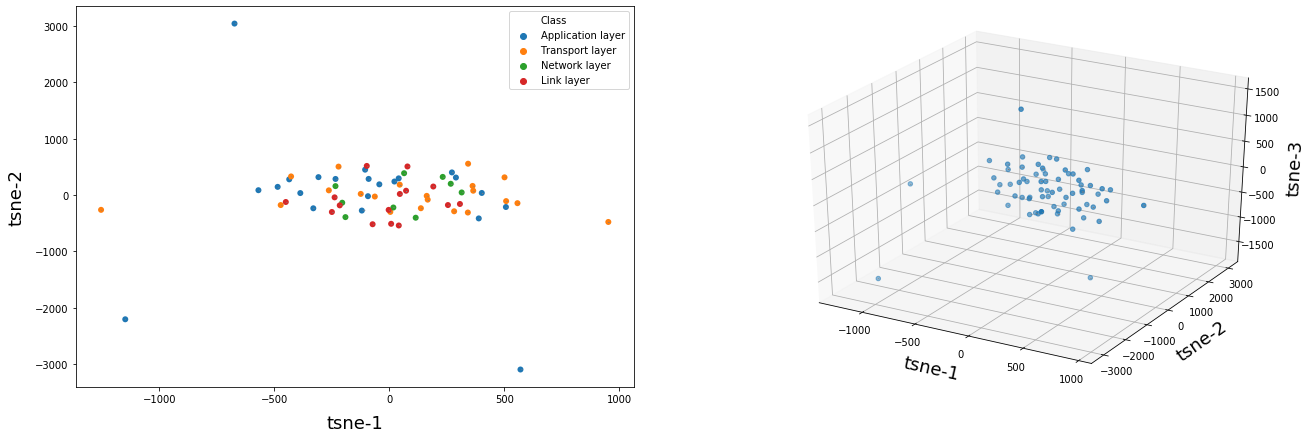

In [18]:
tuples = [("BGP is an application protocol.", 'BGP', 'Application layer'), # designed to exchange routing information among autonomous systems on the Internet
          ("DHCP is an application protocol.", 'DHCP', 'Application layer'), #
          ("FTP is an application protocol.", 'FTP', 'Application layer'), #used for the transfer of computer files between a client and server on a computer network
          ("HTTP is an application protocol.", 'HTTP', 'Application layer'), # for distributed, collaborative, hypermedia information systems
          ("HTTPS is an application protocol.", 'HTTPS', 'Application layer'), # used for secure communication over a computer network
          ("IMAP is an application protocol.", 'IMAP', 'Application layer'), #used by email clients to retrieve email messages from a mail server over a TCP/IP connection
          ("LDAP is an application protocol.", 'LDAP', 'Application layer'), #used for accessing and maintaining distributed directory information services over an IP network
          ("MGCP is an application protocol.", 'MGCP', 'Application layer'), # used in voice over IP telecommunication systems
          ("MQTT is an application protocol.", 'MQTT', 'Application layer'), # that transports messages between devices
          ("NNTP is an application protocol.", 'NNTP', 'Application layer'), #used for transporting Usenet news articles between news servers
          ("NTP is an application protocol.", 'NTP', 'Application layer'), #for clock synchronization between computer systems over packet-switched, variable-latency data networks
          ("POP is an application protocol.", 'POP', 'Application layer'), #used by e-mail clients to retrieve e-mail from a mail server
          ("RTP is an application protocol.", 'RTP', 'Application layer'), # used for delivering audio and video over IP networks
          ("RTSP is an application protocol.", 'RTSP', 'Application layer'), # designed for use in entertainment and communications systems to control streaming media servers
          ("RIP is an application protocol.", 'RIP', 'Application layer'), # which employes the hop count as a routing metric
          ("SIP is an application protocol.", 'SIP', 'Application layer'), # used for initiating, maintaining, and terminating real-time sessions that include voice, video and messaging applications
          ("SMTP is an application protocol.", 'SMTP', 'Application layer'),
          ("SNMP is an application protocol.", 'SNMP', 'Application layer'),
          ("SSH is an application protocol.", 'SSH', 'Application layer'),
          ("Telnet is an application protocol.", 'Telnet', 'Application layer'),
          ("TLS is an application protocol.", 'TLS', 'Application layer'),
          ("XMPP is an application protocol.", 'XMPP', 'Application layer'),
          #
          ("TCP is a transport protocol.", 'TCP', 'Transport layer'),
          ("UDP is a transport protocol.", 'UDP', 'Transport layer'),
          ("DCCP is a transport protocol.", 'DCCP', 'Transport layer'),
          ("SCTP is a transport protocol.", 'SCTP', 'Transport layer'),
          ("RSVP is a transport protocol.", 'RSVP', 'Transport layer'),
          ("CSP is a transport protocol.", 'CSP', 'Transport layer'),
          ("FASP is a transport protocol.", 'FASP', 'Transport layer'),
          ("MTP is a transport protocol.", 'MTP', 'Transport layer'),
          ("LTP is a transport protocol.", 'LTP', 'Transport layer'),
          ("PPTP is a transport protocol.", 'PPTP', 'Transport layer'),
          ("RDP is a transport protocol.", 'RDP', 'Transport layer'),
          ("RUDP is a transport protocol.", 'RUDP', 'Transport layer'),
          ("RDS is a transport protocol.", 'RDS', 'Transport layer'),
          ("SPX is a transport protocol.", 'SPX', 'Transport layer'),
          ("SCCP is a transport protocol.", 'SCCP', 'Transport layer'),
          ("VTP is a transport protocol.", 'VTP', 'Transport layer'),
          ("WDP is a transport protocol.", 'WDP', 'Transport layer'),
          ("WTP is a transport protocol.", 'WTP', 'Transport layer'),
          ("WTLS is a transport protocol.", 'WTLS', 'Transport layer'),
          ("WTCP is a transport protocol.", 'WTCP', 'Transport layer'),
          ("XTP is a transport protocol.", 'XTP', 'Transport layer'),
          #
          ("IP is a network protocol.", 'IP', 'Network layer'),
          ("IPv4 is a network protocol.", 'IPv4', 'Network layer'),
          ("IPv6 is a network protocol.", 'IPv6', 'Network layer'),
          ("ICMP is a network protocol.", 'ICMP', 'Network layer'),
          ("ICMPv6 is a network protocol.", 'ICMPv6', 'Network layer'),
          ("ECN is a network protocol.", 'ECN', 'Network layer'),
          ("IGMP is a network protocol.", 'IGMP', 'Network layer'),
          ("IPsec is a network protocol.", 'IPsec', 'Network layer'),
          ("GGP is a network protocol.", 'GGP', 'Network layer'),
          #
          ("ARP is a link protocol.", 'ARP', 'Link layer'),
          ("NDP is a link protocol.", 'NDP', 'Link layer'),
          ("OSPF is a link protocol.", 'OSPF', 'Link layer'),
          ("L2TP is a link protocol.", 'L2TP', 'Link layer'),
          ("PPP is a link protocol.", 'PPP', 'Link layer'),
          ("DCP is a link protocol.", 'DCP', 'Link layer'),
          ("LCP is a link protocol.", 'LCP', 'Link layer'),
          ("IL2P is a link protocol.", 'IL2P', 'Link layer'),
          ("MRP is a link protocol.", 'MRP', 'Link layer'),
          ("LLDP is a link protocol.", 'LLDP', 'Link layer'),
          ("MSTP is a link protocol.", 'MSTP', 'Link layer'),
          ("PLIP is a link protocol.", 'PLIP', 'Link layer'),
          ("PAgP is a link protocol.", 'PAgP', 'Link layer'),
          ("RLP is a link protocol.", 'RLP', 'Link layer'),
          ("SLPP is a link protocol.", 'SLPP', 'Link layer'),
         ]
run_all(tuples)